In [1]:
import wandb
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import f1_score
from wandb.lightgbm import wandb_callback, log_summary

In [2]:
wandb.login()

wandb: Currently logged in as: d-a-pop (midigpt). Use `wandb login --relogin` to force relogin


True

## Default model (part of the data)

In [8]:
train = pd.read_csv("train.csv")
val = pd.read_csv("val.csv")

In [4]:
train = train.drop("user_id", axis=1)
train = train.drop("book_id", axis=1)
train = train.drop("review_id", axis=1)
train = train.drop("review_text", axis=1)

In [5]:
val = val.drop("user_id", axis=1)
val = val.drop("book_id", axis=1)
val = val.drop("review_id", axis=1)
val = val.drop("review_text", axis=1)

In [4]:
model1 = lgb.LGBMClassifier()

In [7]:
run = wandb.init(project="Goodreads Books Reviews", entity="d-a-pop", job_type="training")

wandb: Currently logged in as: d-a-pop. Use `wandb login --relogin` to force relogin


In [12]:
%%time
gbm = model1.fit(train.drop("rating", axis=1), train["rating"], callbacks=[wandb_callback()]);

CPU times: user 1min 38s, sys: 4.61 s, total: 1min 43s
Wall time: 38 s


In [13]:
ypred1_ = model1.predict_proba(val.drop("rating", axis=1))

In [14]:
ypred1 = np.argmax(ypred1_, axis=1)

In [32]:
f1 = f1_score(val['rating'], ypred1, average='macro')

0.20336674414680866


In [33]:
print(f1)

0.20336674414680866


In [16]:
wandb.log({"F1 Score": f1})

In [9]:
np.ones(len(val))*4

array([4., 4., 4., ..., 4., 4., 4.])

In [21]:
log_summary(gbm.booster_)

In [22]:
run.finish()

F1 Score,▁
iteration,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
F1 Score,0.20337
best_iteration,0
iteration,99


## Default model (whole data, except review text)

In [3]:
train = pd.read_csv("train.csv")
val = pd.read_csv("val.csv")

In [4]:
train['user_id'] = train['user_id'].astype("category")
train['review_id'] = train['review_id'].astype("category")
train['book_id'] = train['book_id'].astype("category")
train = train.drop("review_text", axis=1)

In [5]:
val['user_id'] = val['user_id'].astype("category")
val['review_id'] = val['review_id'].astype("category")
val['book_id'] = val['book_id'].astype("category")
val = val.drop("review_text", axis=1)

In [6]:
model2 = lgb.LGBMClassifier()

In [8]:
train_config = model2.get_params()

In [9]:
run = wandb.init(project="Goodreads Books Reviews", entity="d-a-pop", job_type="training", config=train_config)

wandb: Currently logged in as: d-a-pop. Use `wandb login --relogin` to force relogin


In [10]:
def evaluate_macroF1_lgb(truth, predictions):  
    # this follows the discussion in https://github.com/Microsoft/LightGBM/issues/1483
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

In [11]:
%%time
gbm = model2.fit(train.drop("rating", axis=1), train["rating"], callbacks=[wandb_callback()], \
                 categorical_feature=["user_id", "book_id", "review_id"], eval_metric=evaluate_macroF1_lgb, \
                 eval_set=[(train.drop("rating", axis=1), train["rating"]), (val.drop("rating", axis=1), val["rating"])], \
                 eval_names=["training", "validation"]);

/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['book_id', 'review_id', 'user_id']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	training's multi_logloss: 1.4407	training's macroF1: 0.129422	validation's multi_logloss: 1.44136	validation's macroF1: 0.126793
[2]	training's multi_logloss: 1.41794	training's macroF1: 0.166884	validation's multi_logloss: 1.42109	validation's macroF1: 0.160062
[3]	training's multi_logloss: 1.40037	training's macroF1: 0.186772	validation's multi_logloss: 1.40557	validation's macroF1: 0.180787
[4]	training's multi_logloss: 1.38598	training's macroF1: 0.211647	validation's multi_logloss: 1.39335	validation's macroF1: 0.20397
[5]	training's multi_logloss: 1.37343	training's macroF1: 0.234087	validation's multi_logloss: 1.38286	validation's macroF1: 0.22555
[6]	training's multi_logloss: 1.36292	training's macroF1: 0.249768	validation's multi_logloss: 1.37423	validation's macroF1: 0.240421
[7]	training's multi_logloss: 1.3535	training's macroF1: 0.261333	validation's multi_logloss: 1.36793	validation's macroF1: 0.24707
[8]	training's multi_logloss: 1.34488	training's macroF1: 0.270676	

[62]	training's multi_logloss: 1.17137	training's macroF1: 0.434073	validation's multi_logloss: 1.25994	validation's macroF1: 0.363896
[63]	training's multi_logloss: 1.16964	training's macroF1: 0.435591	validation's multi_logloss: 1.2592	validation's macroF1: 0.364722
[64]	training's multi_logloss: 1.16808	training's macroF1: 0.437168	validation's multi_logloss: 1.25862	validation's macroF1: 0.365087
[65]	training's multi_logloss: 1.16661	training's macroF1: 0.438488	validation's multi_logloss: 1.25797	validation's macroF1: 0.36574
[66]	training's multi_logloss: 1.16508	training's macroF1: 0.439951	validation's multi_logloss: 1.25733	validation's macroF1: 0.366222
[67]	training's multi_logloss: 1.16358	training's macroF1: 0.441174	validation's multi_logloss: 1.25682	validation's macroF1: 0.366757
[68]	training's multi_logloss: 1.16187	training's macroF1: 0.442912	validation's multi_logloss: 1.25632	validation's macroF1: 0.367173
[69]	training's multi_logloss: 1.16039	training's macroF1

In [12]:
# naive f1 score (setting all predictions to 4)
print("Naïve F1 Score:", f1_score(val['rating'], np.ones(len(val))*4, average="macro"))

Naïve F1 Score: 0.08608398236287963


In [18]:
ypred2_ = model2.predict_proba(val.drop("rating", axis=1))
ypred2 = np.argmax(ypred2_, axis=1)

In [22]:
predictions = val[["review_id", "rating"]]
predictions["pred"] = ypred2

<ipython-input-22-6d16ff3950be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions["pred"] = ypred2


In [25]:
table = wandb.Table(dataframe=predictions)

In [26]:
wandb.log({"pred_table":table})

In [27]:
f1 = f1_score(val['rating'], ypred2, average='macro')
print(f1)

0.38027863377250165


<ipython-input-28-87689b9263ca>:1: UserWarning: More than one metric available, picking one to plot.
  lgb.plot_metric(model2, grid=True, figsize=(12, 8));


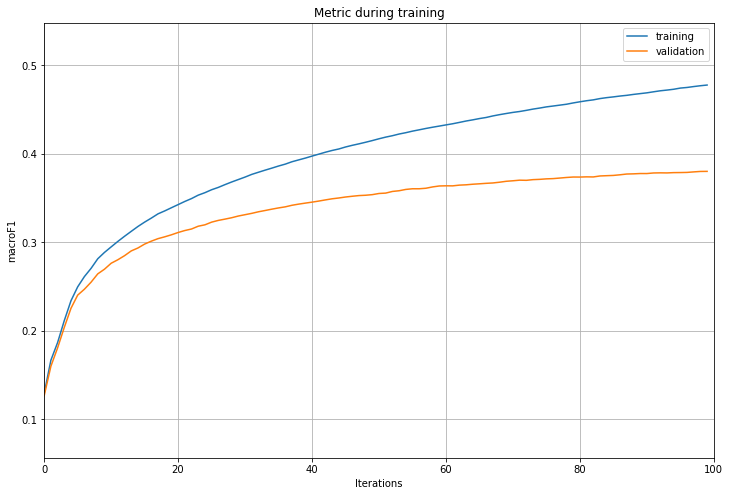

In [28]:
lgb.plot_metric(model2, grid=True, figsize=(12, 8));

In [29]:
log_summary(gbm.booster_)

In [30]:
run.finish()

iteration,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_macroF1,▁▂▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
training_multi_logloss,█▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
validation_macroF1,▁▂▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
validation_multi_logloss,█▇▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
best_iteration,0
iteration,99
training_macroF1,0.47783
validation_macroF1,0.38028


## Submission

In [36]:
test = pd.read_csv("test.csv")

In [37]:
r = test["review_id"]

In [39]:
test['user_id'] = test['user_id'].astype("category")
test['review_id'] = test['review_id'].astype("category")
test['book_id'] = test['book_id'].astype("category")
test = test.drop("review_text", axis=1)

In [40]:
p = model2.predict_proba(test)
s = pd.Series(np.argmax(p, axis=1))

In [41]:
len(s)

478033

In [42]:
len(test)

478033

In [43]:
submission = pd.concat([r,s],axis=1).rename(columns={0: "rating"})

In [44]:
submission

,review_id,rating
0,5c4df7e70e9b438c761f07a4620ccb7c,4
1,8eaeaf13213eeb16ad879a2a2591bbe5,3
2,dce649b733c153ba5363a0413cac988f,4
3,8a46df0bb997269d6834f9437a4b0a77,4
4,d11d3091e22f1cf3cb865598de197599,3
...,...,...
478028,0e1db3d4b04256f9660f5d276ddf1314,5
478029,0b7f352e58caf0fd1f961e98ef04e89c,0
478030,9b19eff33ddb14e9e68fca2e90379e46,5
478031,8be463fed78f0da63e964706f710332b,5


In [45]:
submission.to_csv("sub3.csv", index=False)